<a href="https://www.kaggle.com/yongwonjin/titanic-survival-classification?scriptVersionId=89584554" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Titanic Survival Classification
Based on the notebooks by:  
[Alexis Cook](http://www.kaggle.com/alexisbcook/titanic-tutorial)  
[Francisco Javier Gallego](https://www.kaggle.com/javigallego/top-5-hyperparameter-tuning-ensemble-modeling?scriptVersionId=88795500)  
[Woo Seung Han](https://www.kaggle.com/hadeux/titanic-survivor-predict-eda-lightgbm-kor-eng/notebook)  

In [1]:
# autocomplete ON
%config Completer.use_jedi = False

In [2]:
# Load libraries
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt


<div style='color: white; display: fill; 
    border-radius: 8px; background-color: black;
    font-size: 150%; letter-spacing:0.5px'> 
    <p style='padding: 8px; color: white;'> 
        <b>1 &nbsp; Data prep & EDA</b>
    </p>
</div> 

### <b> 1.1 <span style='color:red'> | </span> Load data </b>

In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [4]:
# Load train and test data
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')
gender_submission = pd.read_csv('../input/titanic/gender_submission.csv')

# Concatenate two data sets
df_data = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)
dfs = [df_train, df_test]

### <b> 1.2 <span style='color:red'> | </span> EDA </b>

In [5]:
## Visually inspect first few rows of each table
df_train.head(3)
# df_test.head(3)
# gender_submission.head(3)

### Task is to predict "Survived" for each "PassengerId"

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
## Show table schema
# df_train.info()
# df_test.info()
df_data.info()

### Excluding the Id and independent variable, there are 10 features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1046 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1307 non-null   object 
 3   Fare         1308 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [7]:
df_data.describe(include='all')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
count,1046.000000,295,1307,1308.000000,1309,1309.000000,1309.000000,1309.000000,1309,1309.000000,891.000000,1309
unique,NaN,186,3,NaN,1307,NaN,NaN,NaN,2,NaN,NaN,929
top,NaN,C23 C25 C27,S,NaN,"Connolly, Miss. Kate",NaN,NaN,NaN,male,NaN,NaN,CA. 2343
freq,NaN,6,914,NaN,2,NaN,NaN,NaN,843,NaN,NaN,11
mean,29.881138,NaN,NaN,33.295479,NaN,0.385027,655.000000,2.294882,NaN,0.498854,0.383838,NaN
std,14.413493,NaN,NaN,51.758668,NaN,0.865560,378.020061,0.837836,NaN,1.041658,0.486592,NaN
min,0.170000,NaN,NaN,0.000000,NaN,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN
25%,21.000000,NaN,NaN,7.895800,NaN,0.000000,328.000000,2.000000,NaN,0.000000,0.000000,NaN
50%,28.000000,NaN,NaN,14.454200,NaN,0.000000,655.000000,3.000000,NaN,0.000000,0.000000,NaN
75%,39.000000,NaN,NaN,31.275000,NaN,0.000000,982.000000,3.000000,NaN,1.000000,1.000000,NaN


In [8]:
# Check for any duplicates
# df_data.Name.duplicated().value_counts()
df_data.duplicated().value_counts()
# df_train[df_train['Name'].isin(df_data[df_data.Name.duplicated()].Name.tolist())]
# df_test[df_test['Name'].isin(df_data[df_data.Name.duplicated()].Name.tolist())]

False    1309
dtype: int64

In [9]:
## Count missing values from each column
# df_train.isna().sum()
df_test.isna().sum()
# df_data.isna().sum()

### Columns "Age", "Cabin", and "Embarked" have missing values

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [10]:
# Functions for drawing pair plots with annotations
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    
def pairPlot(data, column=None):
    if column:
        num = len(data[column].unique())
        g = sns.PairGrid(data, hue=column, hue_kws=sns.color_palette('vlag', n_colors=2, as_cmap=True), dropna=True)
        g.map_offdiag(sns.scatterplot)
        g.add_legend()
    else:
        g = sns.PairGrid(data, dropna=True)
        g.map_offdiag(corrfunc)
        g.map_offdiag(sns.regplot)
    g.map_diag(sns.histplot)
    return g

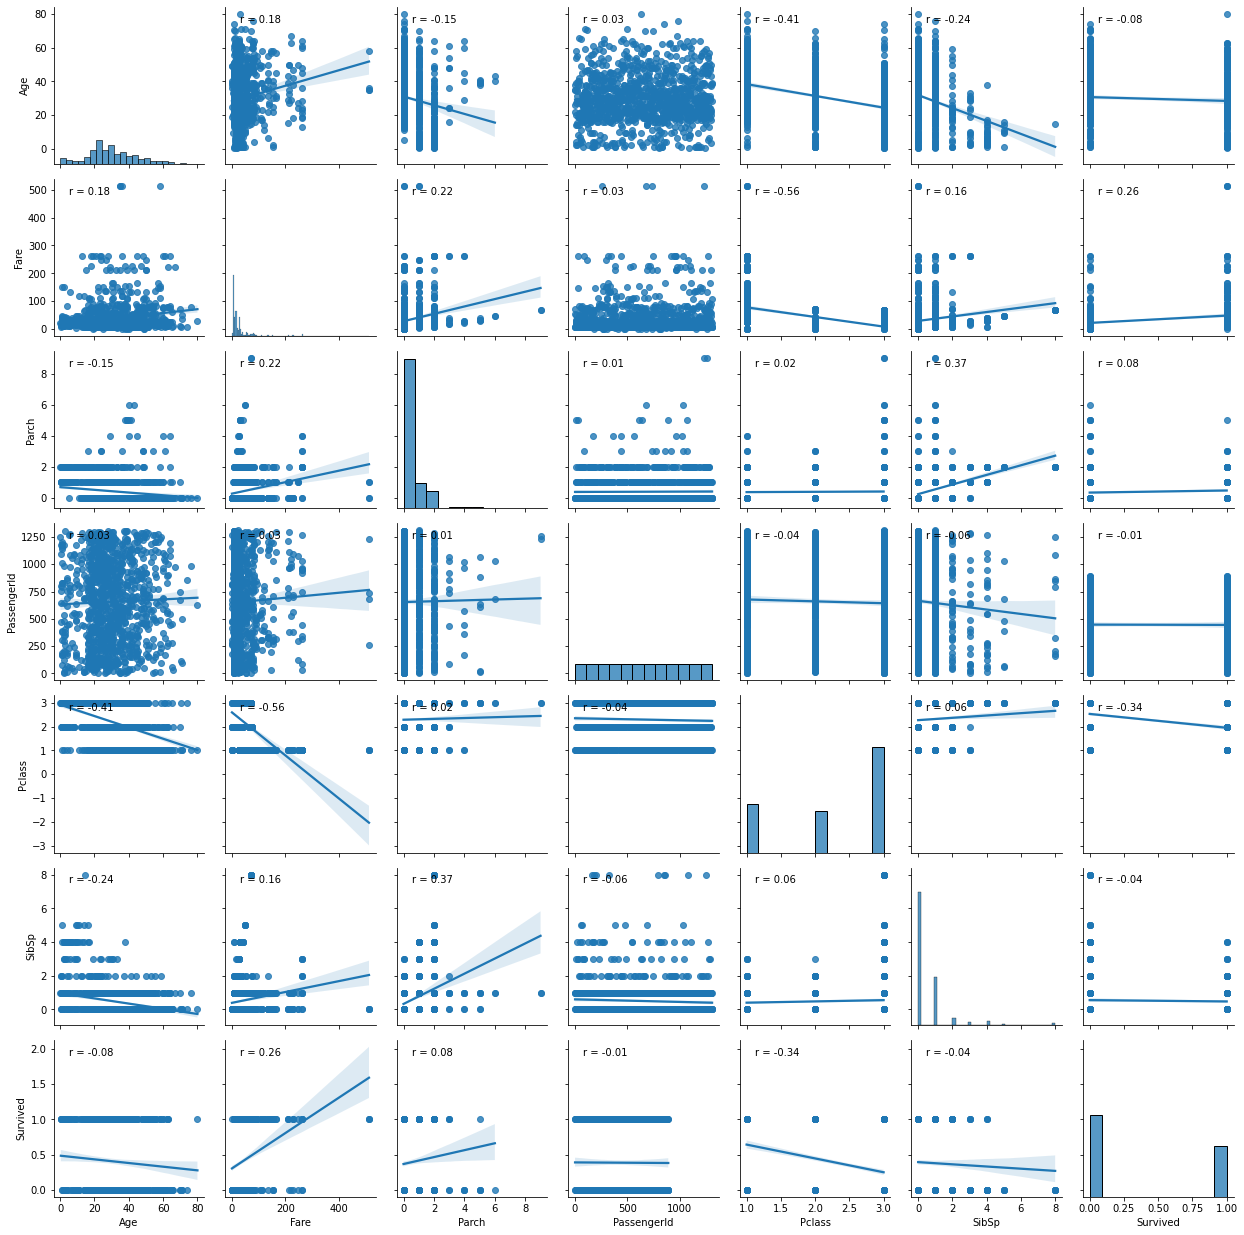

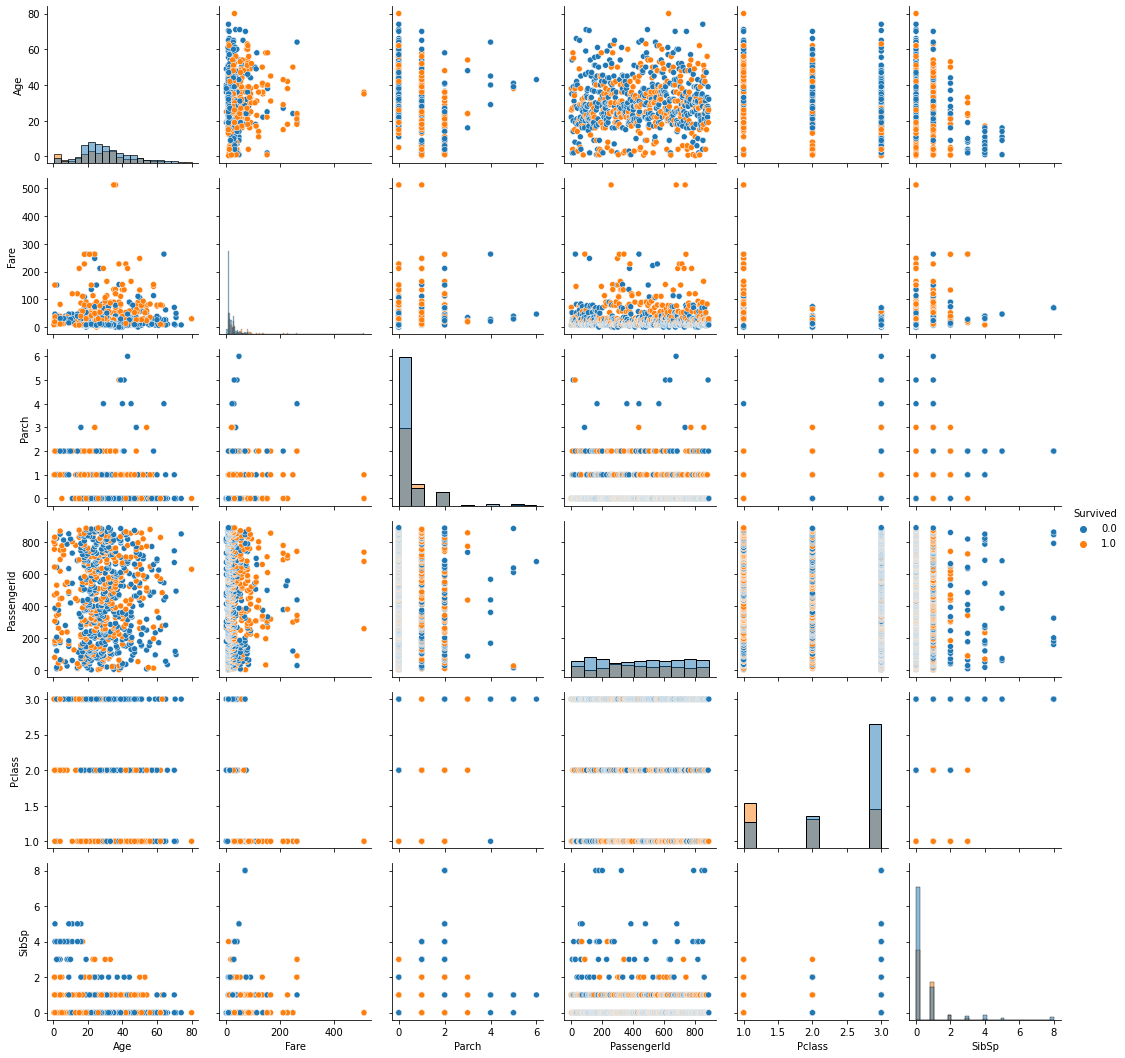

In [11]:
# Visualize pair-wise distribution of numerical features using a pair plot
pairPlot(df_data)
pairPlot(df_data, 'Survived')
# sns.pairplot(data=df_data, kind = 'reg')
# sns.pairplot(data=df_data, kind = 'hist', hue='Survived', palette={0:'blue',1:'green'})

<AxesSubplot:>

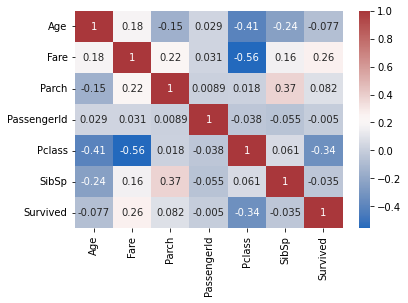

In [12]:
# Heat map to visualize correlation between variables
sns.heatmap(df_data.corr(), annot=True, cmap='vlag')

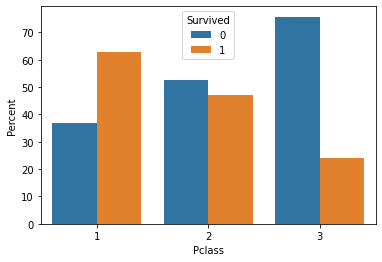

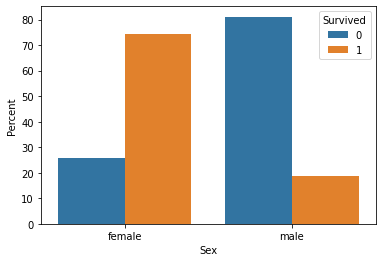

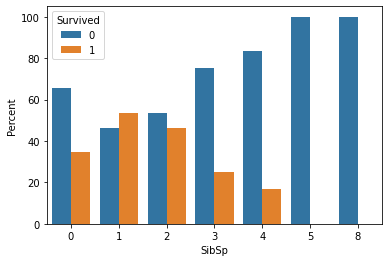

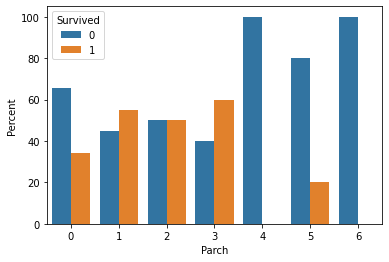

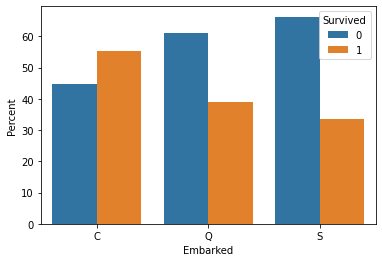

In [13]:
# Tally groups to see which features may be important for survival
# Especially categorical variables not visualized by pair plots above

# df_train.groupby(['Survived', 'Sex']).size()
def categoricalPlots(data, y=None):
    for col in data:
        if col == y:
            continue
        elif (len(data[col].unique())) < 10:
            x=col
            (data
            .groupby(x)[y]
            .value_counts(normalize=True)
            .mul(100)
            .rename('Percent')
            .reset_index()
            .pipe((sns.barplot, 'data'), x=x, y='Percent', hue=y))
            plt.show()
categoricalPlots(df_train, y='Survived')
# sns.countplot(x='Survived', hue='Sex', data = df_train)

**EDA KEY INSIGHTS**
1. There is class imbalance in the trainng set (more people died than survived)
2. There were duplicate names between train and test data sets but upon closer inspection, they seem to be different people with the same names. 
3. There are missing values for the following features: "Age", "Cabin", "Embarked", and "Fare". 
4. "Ticket" and "Cabin" are complex string variables that may be important indicator in predicting survival. 
5. Among numerical features, "Fare" is correlated with survival
6. All categorical features seem to be associated with survival, especially "Sex" and "PClass".  

<div style='color: white; display: fill; 
    border-radius: 8px; background-color: black;
    font-size: 150%; letter-spacing:0.5px'> 
    <p style='padding: 8px; color: white;'> 
        <b>2 &nbsp; Data processing</b>
    </p>
</div> 

### <b> 2.1 <span style='color:orange'> | </span> Feature engineering</b>

##### Title (Honorific)
Some people have titles (ex. Mr. Mrs.) in their names. In addition to biological sex, their titles can signify positions of power and authority (ex. Capt, Countess, Sir, etc.) which may have impacted survival. 

In [14]:
# Extract title (honorifics) from people's names
df_data['Title'] = df_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
# Count occurence for each title
pd.crosstab(df_data['Title'], df_data['Sex']).transpose()

Title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


In [15]:
# Replace upper-class titles with 'Elite' status and unify titles for men and women
df_data['Title'] = df_data['Title'].replace(['Capt', 'Col', 'Countess', 'Dr', 'Jonkheer' ,'Lady', 'Major', 'Rev', 'Sir'], 'Elite')
df_data['Title'] = df_data['Title'].replace(['Ms', 'Mlle', 'Dona'], 'Miss')
df_data['Title'] = df_data['Title'].replace('Mme', 'Mrs')
df_data['Title'] = df_data['Title'].replace('Don', 'Mr')
# Count occurence for each title again
pd.crosstab(df_data['Title'], df_data['Sex']).transpose()

Title,Elite,Master,Miss,Mr,Mrs
Sex,,,,,
female,3,0,265,0,198
male,24,61,0,758,0


In [16]:
# Calculating the mean survival rate for each title/class
df_data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().transpose()

,0,1,2,3,4
Title,Elite,Master,Miss,Mr,Mrs
Survived,0.363636,0.575,0.702703,0.156371,0.793651


##### Surnames
People with same surname may be relatives that boarded the ship together. 

In [17]:
# Extract surnames from name
df_data['Surname'] = df_data.Name.str.extract('^([A-Za-z\'\-\s]+),', expand=False)
# Add new column of counts of people with same surnames
df_data['SurnameCount'] = df_data['Surname'].value_counts()[df_data['Surname']].values

##### Deck
Cabins are located on decks A-G. Which deck a passenger's cabin is located on is associated with "PClass" and can be predictive of survival. 

2208 people were aboard Titanic - 891 of which were crew [(source)](https://www.encyclopedia-titanica.org/titanic/#titanic-passengers-crew)  
Below are passenger capacities for each class on each deck [(source)](https://www.encyclopedia-titanica.org/passenger-accommodation.html) [(source)](https://titanic.fandom.com)

| DECK | FIRST CLASS | SECOND CLASS | THIRD CLASS |
| --- | --- | --- | --- |
| T | 7 | 0 | 0 |
| A | 42 | 0 | 0 |
| B | 123 | 0 | 0 |
| C | 310 | 0 | 0 |
| D | 117 | 118 | 50 |
| E | 97 | 226 | 260 |
| F | 0 | 218 | 466 |
| G | 0 | 112 | 250 |
| **TOTAL** | **689** | **674** | **1026** |

In [18]:
df_data[df_data['Cabin'].notna()]['Cabin'].unique()

array(['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104',
       'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30',
       'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22',
       'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20',
       'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126',
       'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64',
       'E24

In [19]:
df_data['Deck'] = df_data.Cabin.str.extract('^([A-Za-z])', expand=False)
print(df_data['Deck'].value_counts(dropna=False))
### There is one passenger on Deck T
### There are many missing values
pd.crosstab(df_data['Deck'], df_data['Pclass'], margins=True, dropna=False).transpose()

NaN    1014
C        94
B        65
D        46
E        41
A        22
F        21
G         5
T         1
Name: Deck, dtype: int64


Deck,A,B,C,D,E,F,G,T,All
Pclass,,,,,,,,,
1,22,65,94,40,34,0,0,1,323
2,0,0,0,6,4,13,0,0,277
3,0,0,0,0,3,8,5,0,709
All,22,65,94,46,41,21,5,1,1309


In [20]:
# Do research on passenger that was on Deck T
df_data[df_data['Deck']=='T']
### It seems that Mr. Blackwell was on the very top deck above Deck A.
# df_data['Deck'] = df_data['Deck'].replace('T', 'A')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Surname,SurnameCount,Deck
339,45.0,T,S,35.5,"Blackwell, Mr. Stephen Weart",0,340,1,male,0,0.0,113784,Mr,Blackwell,1,T


##### Family size
"Parch" and "SibSp" features can be summed to a new feature: "FamilySize"

In [21]:
# Create new feature: "FamilySize"
df_data['FamilySize'] = df_data['Parch'] + df_data['SibSp'] + 1

"FamilySize" does not account for number of cousins or distant relatives.  
"SurnameCount" may be better indicator for family size

In [22]:
# Inspect rows that have different values for "FamilySize" and "SurnameCount"
df_data[df_data['FamilySize']-df_data['SurnameCount'] != 0][['Cabin','Embarked','Name','Ticket','Surname','SurnameCount','FamilySize']].sort_values(by='Surname')


,Cabin,Embarked,Name,Ticket,Surname,SurnameCount,FamilySize
948,F G63,S,"Abelseth, Mr. Olaus Jorgensen",348122,Abelseth,2,1
1236,NaN,S,"Abelseth, Miss. Karen Marie",348125,Abelseth,2,1
40,NaN,S,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",7546,Ahlin,1,2
210,NaN,S,"Ali, Mr. Ahmed",SOTON/O.Q. 3101311,Ali,2,1
784,NaN,S,"Ali, Mr. William",SOTON/O.Q. 3101312,Ali,2,1
...,...,...,...,...,...,...,...
914,NaN,C,"Williams, Mr. Richard Norris II",PC 17597,Williams,5,2
1053,NaN,S,"Wright, Miss. Marion",220844,Wright,2,1
555,NaN,S,"Wright, Mr. George",113807,Wright,2,1
1027,NaN,C,"Zakarian, Mr. Mapriededer",2656,Zakarian,2,1


Most people that have same surname have similar ticket numbers and embarked from the same port.  
We can see that counting people with the same surname is better indicator of family size.  
In the future, taking "Ticket" and "Embarked" variables into account may help identify people who are not family members that are travelling together.  

# ***Work in progress***

### <b> 2.2 <span style='color:orange'> | </span> Imputation of missing values </b>

In [23]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<div style='color: white; display: fill; 
    border-radius: 8px; background-color: black;
    font-size: 150%; letter-spacing:0.5px'> 
    <p style='padding: 8px; color: white;'> 
        <b>3 &nbsp; Data modeling</b>
    </p>
</div> 

In [24]:
# Percent of women that survived
women = df_train.loc[df_train.Sex == 'female']['Survived']
pct_women = sum(women)/len(women)
print('% of women who survived:', pct_women)

# Percent of men that survived
men = df_train.loc[df_train.Sex == 'male']['Survived']
pct_men = sum(men)/len(men)
print('% of men who survived:', pct_men)

% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924


In [25]:
from sklearn.ensemble import RandomForestClassifier

Y_train = df_train['Survived']

features = ['Pclass', 'Sex', 'SibSp', 'Parch']
X_train = pd.get_dummies(df_train[features])
X_test = pd.get_dummies(df_test[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=7)
model.fit(X_train,Y_train)

RandomForestClassifier(max_depth=5, random_state=7)

In [26]:
predictions = model.predict(X_train)
acc_train = (1 - sum(abs(predictions - Y_train.to_numpy())) / len(predictions))
print('Prediction accuracy on training set: ', acc_train)

Prediction accuracy on training set:  0.8148148148148149


In [27]:
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': df_test.PassengerId, 
                      'Survived': predictions})
# output.to_csv('submission.csv', index=False)
print('Your submission was successfully saved!')

Your submission was successfully saved!
